## Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


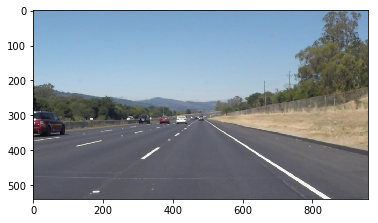

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)



def extrapolate_lines(lines):
    left_x_points = []
    left_y_points = []

    right_x_points = []
    right_y_points = []

    left_slopes = []
    right_slopes = []
    
    
    for line in lines: 
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            # filter out outliers
            if -0.5 < slope < 0.5:
                continue
            if(slope > 0):
                left_x_points.append(x1)
                left_x_points.append(x2)
                left_y_points.append(y1)
                left_y_points.append(y2)
            elif slope < 0:
                right_x_points.append(x1)
                right_x_points.append(x2)                
                right_y_points.append(y1)
                right_y_points.append(y2)

    
    left_lane_line = np.polyfit(left_x_points, left_y_points, 1)
    right_lane_line = np.polyfit(right_x_points, right_y_points, 1)
    
    
    top_y = 325
    bottom_y = image.shape[0]
    bottom_left_x = int(abs((bottom_y - left_lane_line[1]) / left_lane_line[0]))
    bottom_right_x = int(abs((bottom_y - right_lane_line[1]) / right_lane_line[0])) 
    top_left_x = int(abs((top_y - left_lane_line[1]) / left_lane_line[0]))
    top_right_x = int(abs((top_y - right_lane_line[1]) / right_lane_line[0]))
    
    #drawing the lines on the actual image
    left_line = np.array([[bottom_left_x, bottom_y, top_left_x, top_y]])
    right_line = np.array([[bottom_right_x, bottom_y, top_right_x, top_y]])
    return np.array([right_line, left_line])



def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    z = extrapolate_lines(lines)

    draw_lines(line_img, z)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lane_lines(input_image):
    
#   print("starting draw_lane_lines")
    image = np.copy(input_image)
    height = image.shape[0]
    width = image.shape[1]
    
    # 1. Grayscale Image
    gray = grayscale(image)
    
    left_bottom = (0, height)
    right_bottom = (width, height)
    apex = (width / 2, height / 2 + 40)
    print(apex)
    
    vertices = np.array([[left_bottom, apex, right_bottom]], dtype=np.int32)
    
    gray_blur = gaussian_blur(gray, 5)
    
    edges = canny(gray_blur, 50, 150)    

    area_of_interest = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 20
    line_image = hough_lines(area_of_interest, rho, theta, threshold, min_line_length, max_line_gap)    
    projected_image = weighted_img(line_image, input_image)
    return projected_image




## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

(480.0, 310.0)
(480.0, 310.0)
(480.0, 310.0)
(480.0, 310.0)
(480.0, 310.0)
(480.0, 310.0)


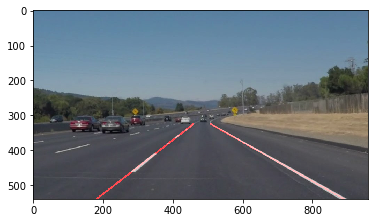

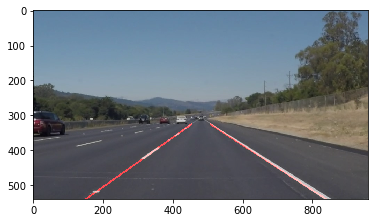

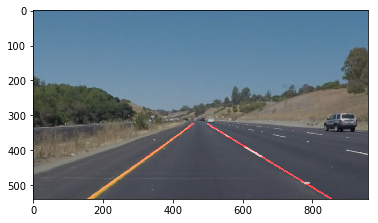

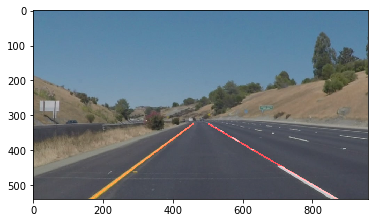

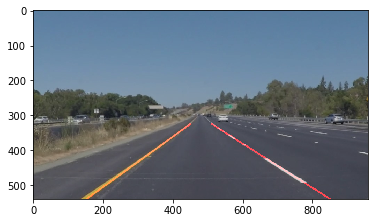

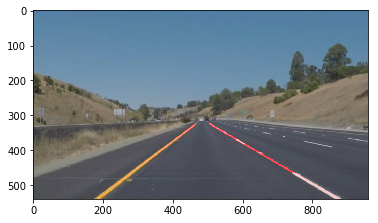

In [4]:
import os

input_dir = "test_images/";
output_dir = "test_images_output/";

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
images = os.listdir(input_dir);

for image_to_read in images:
    image_in = mpimg.imread(input_dir+image_to_read)
    
    image_out = draw_lane_lines(image_in)
    
    plt.figure();
    plt.imshow(image_out)
    
    img_write = cv2.cvtColor(image_out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_dir+image_to_read, img_write)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Steps:

To find lines:
1. Copy image for editing
2. Gray scale image
3. Gaussian Blur image
4. Canny edge detection 
5. Region mask area of interest
6. Hough transform 
7. Impose result of Hoough transform on orginal image

To create two solid lane lines:
1. Remove all lines that have very low or very high slope to remove noise (adjust this while testing)
2. Seperate positive and negative slopes for left and right lanes then for each side:
3. Average the slopes of the lines m_average
4. Average the b values of the lines b_average
5. Create a line with m_average and b_average and impose on image

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.



            
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
x = draw_lane_lines(image)

image = mpimg.imread('test_images/solidWhiteCurve.jpg')
y = draw_lane_lines(image)


# plt.imshow(x)
# plt.show()

import os

input_dir = "test_images/";
output_dir = "test_images_output/";



(480.0, 310.0)
(480.0, 310.0)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [87]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [88]:
def process_image(input_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    
    image = np.copy(input_image)
    height = image.shape[0]
    width = image.shape[1]
    
    # 1. Grayscale Image
    gray = grayscale(image)
    
    left_bottom = (0, height)
    right_bottom = (width, height)
    apex = (width / 2, height / 2 + 40)
    
    vertices = np.array([[left_bottom, apex, right_bottom]], dtype=np.int32)
    
    gray_blur = gaussian_blur(gray, 5)
    
    edges = canny(gray_blur, 50, 150)    

    area_of_interest = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 20
    line_image = hough_lines(area_of_interest, rho, theta, threshold, min_line_length, max_line_gap)    
    projected_image = weighted_img(line_image, input_image)
    plt.imshow(projected_image)
    return projected_image


Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 49%|████▊     | 122/251 [00:08<00:09, 14.12it/s]

TypeError: expected non-empty vector for x

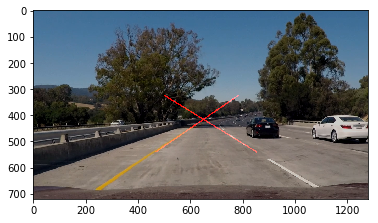

 49%|████▊     | 122/251 [00:20<00:21,  6.10it/s]

In [90]:
white_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

line format:  [[468 540 736 350]]
line format:  [[857 540 548 350]]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

line format:  [[468 540 736 350]]
line format:  [[857 540 548 350]]


  1%|          | 2/251 [00:00<00:21, 11.80it/s]

line format:  [[473 540 760 350]]
line format:  [[858 540 537 350]]
line format:  [[472 540 774 350]]
line format:  [[859 540 546 350]]


  2%|▏         | 4/251 [00:00<00:20, 12.28it/s]

line format:  [[481 540 768 350]]
line format:  [[858 540 550 350]]
line format:  [[485 540 774 350]]
line format:  [[856 540 552 350]]


  2%|▏         | 6/251 [00:00<00:19, 12.63it/s]

line format:  [[484 540 759 350]]
line format:  [[863 540 532 350]]
line format:  [[486 540 750 350]]
line format:  [[989 540 252 350]]


  3%|▎         | 8/251 [00:00<00:18, 13.02it/s]

line format:  [[483 540 756 350]]
line format:  [[860 540 544 350]]
line format:  [[483 540 754 350]]
line format:  [[860 540 547 350]]


  4%|▍         | 10/251 [00:00<00:18, 13.34it/s]

line format:  [[484 540 739 350]]
line format:  [[857 540 537 350]]
line format:  [[489 540 750 350]]
line format:  [[857 540 541 350]]


  5%|▍         | 12/251 [00:00<00:17, 13.61it/s]

line format:  [[483 540 739 350]]
line format:  [[863 540 556 350]]
line format:  [[483 540 734 350]]
line format:  [[861 540 544 350]]


  6%|▌         | 14/251 [00:01<00:17, 13.89it/s]

line format:  [[476 540 788 350]]
line format:  [[856 540 537 350]]
line format:  [[492 540 732 350]]
line format:  [[861 540 533 350]]


  6%|▋         | 16/251 [00:01<00:16, 14.08it/s]

line format:  [[493 540 774 350]]
line format:  [[868 540 526 350]]
line format:  [[479 540 735 350]]
line format:  [[869 540 533 350]]


  7%|▋         | 18/251 [00:01<00:16, 14.10it/s]

line format:  [[487 540 748 350]]
line format:  [[851 540 566 350]]
line format:  [[485 540 748 350]]
line format:  [[858 540 527 350]]


  8%|▊         | 20/251 [00:01<00:16, 14.08it/s]

line format:  [[483 540 745 350]]
line format:  [[860 540 531 350]]
line format:  [[485 540 750 350]]
line format:  [[1156  540  760  350]]


  9%|▉         | 22/251 [00:01<00:16, 13.80it/s]

line format:  [[485 540 761 350]]
line format:  [[856 540 547 350]]
line format:  [[483 540 750 350]]
line format:  [[856 540 551 350]]


 10%|▉         | 24/251 [00:01<00:16, 13.70it/s]

line format:  [[477 540 735 350]]
line format:  [[834 540 337 350]]
line format:  [[469 540 757 350]]
line format:  [[857 540 547 350]]


 10%|█         | 26/251 [00:01<00:16, 13.50it/s]

line format:  [[481 540 766 350]]
line format:  [[857 540 546 350]]
line format:  [[477 540 742 350]]
line format:  [[858 540 545 350]]


 11%|█         | 28/251 [00:02<00:16, 13.70it/s]

line format:  [[483 540 745 350]]
line format:  [[ 619  540 1103  350]]
line format:  [[480 540 740 350]]
line format:  [[857 540 551 350]]


 12%|█▏        | 30/251 [00:02<00:15, 13.94it/s]

line format:  [[482 540 751 350]]
line format:  [[855 540 548 350]]
line format:  [[482 540 751 350]]
line format:  [[852 540 544 350]]


 13%|█▎        | 32/251 [00:02<00:15, 13.99it/s]

line format:  [[482 540 766 350]]
line format:  [[848 540 576 350]]
line format:  [[478 540 733 350]]
line format:  [[850 540 558 350]]


 14%|█▎        | 34/251 [00:02<00:15, 13.83it/s]

line format:  [[474 540 743 350]]
line format:  [[871 540 389 350]]
line format:  [[479 540 760 350]]
line format:  [[850 540 547 350]]


 14%|█▍        | 36/251 [00:02<00:15, 13.94it/s]

line format:  [[483 540 760 350]]
line format:  [[852 540 537 350]]
line format:  [[486 540 769 350]]
line format:  [[854 540 537 350]]


 15%|█▌        | 38/251 [00:02<00:15, 13.93it/s]

line format:  [[476 540 790 350]]
line format:  [[852 540 548 350]]
line format:  [[ 395  540 1814  350]]
line format:  [[853 540 504 350]]


 16%|█▌        | 40/251 [00:02<00:15, 13.97it/s]

line format:  [[479 540 760 350]]
line format:  [[875 540 495 350]]
line format:  [[477 540 747 350]]
line format:  [[848 540 573 350]]


 17%|█▋        | 42/251 [00:03<00:14, 14.12it/s]

line format:  [[476 540 750 350]]
line format:  [[864 540 524 350]]
line format:  [[485 540 766 350]]
line format:  [[854 540 555 350]]


 18%|█▊        | 44/251 [00:03<00:14, 13.92it/s]

line format:  [[484 540 760 350]]
line format:  [[863 540 523 350]]
line format:  [[477 540 752 350]]
line format:  [[859 540 525 350]]


 18%|█▊        | 46/251 [00:03<00:14, 13.81it/s]

line format:  [[483 540 765 350]]
line format:  [[857 540 533 350]]
line format:  [[476 540 734 350]]
line format:  [[859 540 539 350]]


 19%|█▉        | 48/251 [00:03<00:14, 13.57it/s]

line format:  [[481 540 742 350]]
line format:  [[863 540 550 350]]
line format:  [[464 540 750 350]]
line format:  [[856 540 541 350]]


 20%|█▉        | 50/251 [00:03<00:14, 13.66it/s]

line format:  [[469 540 771 350]]
line format:  [[857 540 545 350]]
line format:  [[489 540 765 350]]
line format:  [[857 540 552 350]]


 21%|██        | 52/251 [00:03<00:14, 13.74it/s]

line format:  [[475 540 735 350]]
line format:  [[892 540 486 350]]
line format:  [[496 540 744 350]]
line format:  [[866 540 536 350]]


 22%|██▏       | 54/251 [00:03<00:14, 13.53it/s]

line format:  [[479 540 721 350]]
line format:  [[851 540 570 350]]
line format:  [[480 540 743 350]]
line format:  [[854 540 565 350]]


 22%|██▏       | 56/251 [00:04<00:14, 13.58it/s]

line format:  [[476 540 718 350]]
line format:  [[858 540 525 350]]
line format:  [[477 540 739 350]]
line format:  [[854 540 557 350]]


 23%|██▎       | 58/251 [00:04<00:14, 13.63it/s]

line format:  [[476 540 734 350]]
line format:  [[863 540 148 350]]
line format:  [[481 540 737 350]]
line format:  [[855 540 544 350]]
line format:  [[474 540 734 350]]
line format:  [[857 540 563 350]]


 24%|██▍       | 60/251 [00:04<00:14, 13.21it/s]

line format:  [[471 540 743 350]]
line format:  [[859 540 540 350]]
line format:  [[461 540 764 350]]
line format:  [[859 540 539 350]]


 25%|██▍       | 62/251 [00:04<00:14, 13.01it/s]

line format:  [[477 540 746 350]]
line format:  [[868 540 532 350]]
line format:  [[490 540 735 350]]
line format:  [[864 540 550 350]]


 25%|██▌       | 64/251 [00:04<00:14, 12.71it/s]

line format:  [[489 540 754 350]]
line format:  [[870 540 526 350]]


 26%|██▋       | 66/251 [00:04<00:14, 12.85it/s]

line format:  [[485 540 750 350]]
line format:  [[859 540 557 350]]
line format:  [[489 540 745 350]]
line format:  [[869 540 520 350]]


 27%|██▋       | 68/251 [00:05<00:14, 12.89it/s]

line format:  [[484 540 741 350]]
line format:  [[859 540 559 350]]
line format:  [[479 540 741 350]]
line format:  [[863 540 544 350]]


 28%|██▊       | 70/251 [00:05<00:13, 12.96it/s]

line format:  [[487 540 740 350]]
line format:  [[861 540 554 350]]
line format:  [[489 540 759 350]]
line format:  [[864 540 547 350]]


 29%|██▊       | 72/251 [00:05<00:13, 13.11it/s]

line format:  [[492 540 753 350]]
line format:  [[864 540 539 350]]
line format:  [[481 540 759 350]]
line format:  [[866 540 546 350]]


 29%|██▉       | 74/251 [00:05<00:13, 13.21it/s]

line format:  [[475 540 767 350]]
line format:  [[900 540 133 350]]
line format:  [[490 540 748 350]]
line format:  [[874 540 528 350]]


 30%|███       | 76/251 [00:05<00:13, 13.31it/s]

line format:  [[482 540 721 350]]
line format:  [[870 540 532 350]]
line format:  [[495 540 746 350]]
line format:  [[890 540 486 350]]


 31%|███       | 78/251 [00:05<00:13, 13.21it/s]

line format:  [[491 540 741 350]]
line format:  [[863 540 518 350]]
line format:  [[495 540 763 350]]
line format:  [[927 540 339 350]]


 32%|███▏      | 80/251 [00:05<00:12, 13.32it/s]

line format:  [[500 540 725 350]]
line format:  [[868 540 550 350]]
line format:  [[486 540 721 350]]
line format:  [[869 540 499 350]]


 33%|███▎      | 82/251 [00:06<00:12, 13.29it/s]

line format:  [[481 540 721 350]]
line format:  [[875 540 534 350]]
line format:  [[479 540 724 350]]
line format:  [[873 540 533 350]]


 33%|███▎      | 84/251 [00:06<00:12, 13.32it/s]

line format:  [[479 540 715 350]]
line format:  [[871 540 489 350]]
line format:  [[475 540 747 350]]
line format:  [[859 540 289 350]]


 34%|███▍      | 86/251 [00:06<00:12, 13.15it/s]

line format:  [[474 540 767 350]]
line format:  [[889 540 485 350]]
line format:  [[451 540 735 350]]
line format:  [[861 540 554 350]]


 35%|███▌      | 88/251 [00:06<00:12, 13.11it/s]

line format:  [[498 540 732 350]]
line format:  [[861 540 551 350]]
line format:  [[451 540 761 350]]
line format:  [[ 144  540 3203  350]]
line format:  [[461 540 731 350]]
line format:  [[864 540 534 350]]


 36%|███▌      | 90/251 [00:06<00:12, 12.69it/s]

line format:  [[429 540 763 350]]
line format:  [[864 540 542 350]]
line format:  [[444 540 821 350]]
line format:  [[1177  540 1206  350]]


 37%|███▋      | 92/251 [00:06<00:12, 12.26it/s]

line format:  [[449 540 728 350]]
line format:  [[1155  540 1814  350]]


 37%|███▋      | 94/251 [00:07<00:14, 10.68it/s]

line format:  [[467 540 790 350]]
line format:  [[1147  540  381  350]]
line format:  [[456 540 771 350]]
line format:  [[896 540 342 350]]


 38%|███▊      | 96/251 [00:07<00:14, 10.76it/s]

line format:  [[477 540 740 350]]
line format:  [[871 540 532 350]]
line format:  [[462 540 754 350]]
line format:  [[859 540 108 350]]


 39%|███▉      | 98/251 [00:07<00:13, 11.21it/s]

line format:  [[489 540 874 350]]
line format:  [[ 343  540 1167  350]]
line format:  [[487 540 781 350]]
line format:  [[ 551  540 1019  350]]
line format:  [[436 540 802 350]]
line format:  [[875 540 524 350]]


 40%|███▉      | 100/251 [00:07<00:13, 11.50it/s]

line format:  [[ 570  540 1099  350]]
line format:  [[850 540 547 350]]


 41%|████      | 102/251 [00:07<00:13, 11.20it/s]

line format:  [[487 540 746 350]]
line format:  [[ 374  540 1416  350]]
line format:  [[490 540 732 350]]
line format:  [[831 540   3 350]]
line format:  [[496 540 757 350]]
line format:  [[845 540 217 350]]


 42%|████▏     | 106/251 [00:08<00:12, 11.99it/s]

line format:  [[535 540 879 350]]
line format:  [[823 540 499 350]]
line format:  [[557 540 966 350]]
line format:  [[860 540 505 350]]
line format:  [[ 687  540 1488  350]]
line format:  [[845 540 515 350]]


 43%|████▎     | 108/251 [00:08<00:13, 10.70it/s]

line format:  [[1378  540 2937  350]]
line format:  [[831 540 512 350]]
line format:  [[ 878  540 2406  350]]
line format:  [[813 540 501 350]]
line format:  [[ 359  540 1137  350]]
line format:  [[755 540 387 350]]


 44%|████▍     | 110/251 [00:08<00:13, 10.75it/s]

line format:  [[ 668  540 1571  350]]
line format:  [[823 540 553 350]]


 45%|████▍     | 112/251 [00:08<00:12, 11.53it/s]

line format:  [[465 540 743 350]]
line format:  [[784 540 541 350]]
line format:  [[1312  540 2968  350]]
line format:  [[841 540 566 350]]


 45%|████▌     | 114/251 [00:08<00:11, 12.28it/s]

line format:  [[470 540 770 350]]
line format:  [[828 540 604 350]]


 46%|████▌     | 116/251 [00:08<00:10, 12.80it/s]

line format:  [[472 540 778 350]]
line format:  [[872 540 534 350]]
line format:  [[488 540 772 350]]
line format:  [[856 540 553 350]]
line format:  [[511 540 796 350]]
line format:  [[865 540 540 350]]


 47%|████▋     | 118/251 [00:09<00:10, 12.95it/s]

line format:  [[516 540 869 350]]
line format:  [[855 540 540 350]]
line format:  [[517 540 853 350]]
line format:  [[858 540 526 350]]


 48%|████▊     | 120/251 [00:09<00:09, 13.22it/s]

line format:  [[ 772  540 2888  350]]
line format:  [[857 540 522 350]]


 49%|████▊     | 122/251 [00:09<00:09, 13.09it/s]

line format:  [[442 540 799 350]]
line format:  [[844 540 508 350]]
line format:  [[469 540 747 350]]
line format:  [[854 540 543 350]]


TypeError: expected non-empty vector for x

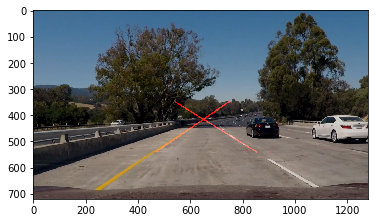

In [73]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))